# The Hopfield network

A Hopfield network is a form of recurrent artificial neural network popularized by John Hopfield in [1982](http://www.ncbi.nlm.nih.gov/pubmed/6953413).   It is an autoassociative network, which means that it can store a piece of data given as the activation of its own units and then retrieve it when you trigger a subpopulation of its units that is equal to a tiny sample of the same piece of data.
Learning is done by changing the weights of the connections between its units in a  *fake* hebbian way. You treat each input pattern as if it were the vector of the activations of units and highten the weights of the connections between concurrently active units. 

figure 1: an abstract example showing the functioning of an autoassociative network. On the left the network weights after learning. On the center, we trigger only one unit. On the right, all the associated units become activated.

![figure_1](hopfield.png)

<div>Table of contents</div>
<div id="toc"></div>

### Spreading of activations

The activation of a unit in a Hopfield network is updated by evaluating the sign of the weighted sum of its inputs:

![](sign_function.png)

$$ 
x_i = \begin{cases}
  -1  & \quad \text{if } \sum_{j} w_{ij}x_j <  0\\
   1  & \quad \text{otherwise}\\
  \end{cases}
$$ 

There are two ways to implement the update of the units: **synchronous** and **asynchronous** update.  

#### Syncronous update

The units are updated altogether at each step, using as inputs the *freezed* activations of themselves at the previous step. 

In python you can write:

```python
# n = len(x)
for i in xrange(n): 
    w_sum = 0
    for j in xrange(n):
        w_sum += w[i,j]*x_previous[j]
    x[i] = sgn(w_sum)
...
...
x_previous = x
```
Using linear algebra we can rewrite it in a shorter form as:
$$
\mathbf{x} = sgn(\mathbf{W}\mathbf{x})
$$
where $\mathbf{x}$ is the vector of activations, $\mathbf{W}$ is the matrix of inner weights and $\mathbf{W}\mathbf{x}$ is the [dot product](https://en.wikipedia.org/wiki/Dot_product#Algebraic_definition), a linear algebra operator that allows to calculate the  weighted sum at once. 
Linear algebra notation is a far better way to implement neural networks in a program than iterating units. In particular, writing formulas with linear algebra notation in python (through the numpy library) improves both speed and readability. In the case of units activations in python you can write:
```python
x = sgn(dot(w,x))
```
*Using linear algebra in a neural network implementation is far simpler than writing loops, it is less error prone and also produces a much efficient code in terms of speed!!*

#### Asynchronous update

At each step a unit is randomly chosen for the update, while the others remain immutated. In python you write:
```python
i = chosen_index
w_sum = 0
for j in xrange(n):
    w_sum += w[i,j]*x[j]
x[i] = sgn(w_sum)
```
Using linear algebra leads to a shorter form also in this case:

```python
i = chosen_index
x[i] = sgn(w[i,:],x)
```
Note how we don't need to store previous values here. 

In the simulation described below we will use asynchronous update (in a way it seems more biologicaly plausible).

### Learning

The learning of the weights is done offline at the start of the simulation. To update the weights you just treat each pattern $\mathbf{p}_k$ (with $k = 1,...,n_p$) as if it were the current vector of activations of the network units and increase those weights where the activity at the two endings are high ([hebbian learning](https://en.wikipedia.org/wiki/Hebbian_theory#Principles)). This is done in practice by multiplying the two activities at the endings of each weight. The total amount of update is then calculated by adding together all the increments due to the different patterns to be learned. Finally the result is divided times the number of patterns to learn so that the weights are normalized. Putting it all together you have:
$$
w_{i,j} = \frac{1}{n_p} \sum_k p^k_i p^k_j 
$$
In python we can write:
```python
w = zeros([n,n])
# P is an array of p vectors 
for p in P:    
    # np = len(p)
    for i in xrange(np):  
        for j in xrange(np):
            # autoconnections are 
            # forbidden in Hopfield nets
            if i != j :     
                w[i,j] += (1/float(np))*p[i]*p[j]
```
Where `P` is an array with `np` rows of `p` patterns.

Once again linear algebra can help us and we can rewrite the learning rule as:
$$
    \mathbf{W} = \frac{1}{n_p}\sum_k \mathbf{p}_k \mathbf{p}_k^T
$$
Where  $ \mathbf{p}_k \mathbf{p}_k^T$ is the [outer product](https://en.wikipedia.org/wiki/Outer_product#Definition_.28matrix_multiplication.29) of $\mathbf{p}_k$ with itself. In python it becomes:
```python
# accumulate dot products
for p in P:
    w += (1/float(np))*outer(p,p)

# cut autoconnections afterward
w *= 1.0 - eye(n,n)     
```
In this case we have only one loop instead of three!! 
<p></p>



>* A general rule: the **dot product** is for spreading the activity throughout a network, while the **outer product** is for weight update

### Energy function
In each state of the network we can calculate a value that is given by:
$$
E = -\frac{1}{2}\sum_{i,j}w_{i,j}x_{i}x_{j}
$$
or in linear algebra notation:
$$
E = -\frac{1}{2} \mathbf{x}^T\mathbf{W}\mathbf{x}
$$
Hopfield proved that this value can only decrease or stay the same. When $E$ ceases to change the network has reached one of its attractor states. if the learned patterns are sufficiently orthogonal with each other attractor states correspond to the recalled patterns.

In python it is:
```python
E = -0.5*dot(x,dot(w,x))
```

### Storing and recalling MNIST digits

In [11]:
%matplotlib inline
from pylab import *

Let us implement a simulation using images from [the MNIST dataset](http://nbviewer.ipython.org/github/francesco-mannella/neunet-basics/blob/master/course/mnist.ipynb) as patterns.

#### Initialize the dataset
First we initialize the dataset:

In [12]:
#### Download the dataset 
# Get the script from internet
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  

# Run it to dovnload all files in a local dir named 'data'
! bash get_data.sh >/dev/null 2>&1

# We do not need the script anymore, remove it
! rm get_data.sh* > /dev/null 2>&1

# Initialize the dataset variables
%run utils

We now fill a array with all parameters. We only need few samples, we take them from the training set. 
We take samples 2 and 5, representing respectively a '4' and a '2'

In [13]:
# Take two rows
patterns = array(mndata.train_images)[[2,5],]

# We need only the sign (transform to binary input)
patterns = sign(patterns/255.0 - 0.5)

# Set the number of patterns (two in out case)
n_patterns = patterns.shape[0]

Let us visualize our two patterns:

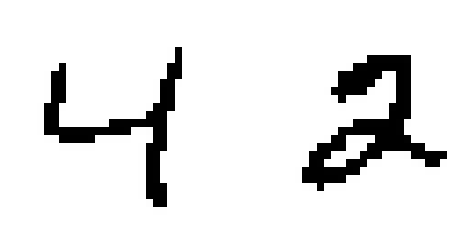

In [14]:
fig = figure(figsize = (8, 4))
for i in xrange(n_patterns):
    plot_img( to_mat(patterns[i]), 
             fig, i+1, windows = 2 )

#### Weights update

Learning of the weight happens offline at the beginning, in one shot:

In [15]:
# Initialize weights to zero values
W = zeros([n,n])

# Accumulate outer products 
for pattern in patterns :
    W += outer(pattern, pattern)

# Divide times the number of patterns
W /= float(n_patterns)

# Exclude the autoconnections
W *= 1.0 - eye(n, n)

#### Iterating the timesteps

Now we implement the core part, defining what happens in each timestep

In [16]:
# Number of timesteps
stime = 1000

# Number of samples to store as long 
# as spreading goes on
samples = 100

# Timestep interval between two samples
sint = stime/samples

# Init the stories of spreading as a zero array,
# we will fill it in at each timestep and we will 
# plot it at the end
store_images = zeros([n_patterns, n, samples])

# Init the stories of energy as a zero array,
# we will fill it in at each timestep and we will 
# plot it at the end
E = zeros([n_patterns, stime])

# We simulate two iterations, each one starting
# with a coorupted version of one of our two patterns
for target_index in xrange(n_patterns) :

    # Copy the original pattern
    target = patterns[target_index]
    x = target.copy()
    
    # Then modify the second half of the image 
    # putting random binary values
    x[(n/2):] = sign(randn(n/2))

    
    # During the iterations we need to peek 
    # one unit at random. Thus we must prepare
    # a random sequence of indices:
    #    we get the sequence of indices 
    #    of the network units
    x_indices = arange(n)
    
    #    and we shuffle it
    shuffle(x_indices)
    
    # the iterations
    for t in xrange(stime) :
        # Get the current index browsing 
        # the random sequence 
        current_x = x_indices[t%n]   
        
        # Activation of a unit
        x[current_x] = sign(dot(W[current_x,:], x))
        
        # Energy of the current state of the network
        E[target_index, t] = -0.5*dot(x, dot(W, x))
        
        # Store current activations
        if stime%sint == 0 :
            store_images[target_index,:,t/sint] = x

#### Plotting
We will create two animations showing the network moving from the initial corrupted patterns to the correct attractor states.

In [17]:
# The matplotlib object to do animations
from matplotlib import animation

# This grid allows to layout subplots in a more
# flexible way
import matplotlib.gridspec as gridspec

# Initialize the figure for the animation    
# Initialize the figure for the animation    
# target_index :  int     The index of the target 
#                         to plot
# returns      :  tuple   The three plotting objects 
#                         to render    
def init_fig(target_index) :    
  
    # This is the target digit
    target = patterns[target_index]
    
    # Init the grid and the figure
    gs = gridspec.GridSpec(8, 20)
    fig = figure(figsize=(8, 3.5))        

    #-------------------------------------------------
    # Plot 1 - plot the target digit
    
    # Create subplot
    ax1 = fig.add_subplot(gs[:4,:4])
    
    title("target")
    
    # Create the imshow and save the handler
    im_target = ax1.imshow(to_mat(target), 
                           interpolation = 'none', 
                           aspect = 'auto',
                           cmap = cm.binary) 
    axis('off')

    
    #-------------------------------------------------
    # Plot 2 - plot the current state of the network
    
    # Create subplot
    ax2 = fig.add_subplot(gs[:4,6:10])
  
    title("recalling")
   
    # Create the imshow and save the handler
    im_x = ax2.imshow(to_mat(x), 
                      interpolation = 'none', 
                      aspect = 'auto',
                      cmap = cm.binary) 
    axis('off')

    #-------------------------------------------------
    # Plot 3 - plot the current history of energy
    
    # Create subplot
    ax3 = fig.add_subplot(gs[:4,12:])
 
    title("Energy")
   
    # Create the line plot and save the handler
    im_E, = ax3.plot(E[target_index])
    
    # Only bottom-left axes - no tics
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # Return the handlers
    return fig,im_target,im_x,im_E

# Updates images at each frame of the animation
# data    : list of tuples    Each row contains the
#                             arguments of update for 
#                             a frame
# returns : tuple             The handlers of the 
#                             images 
def update(data) :

    # unpack data
    image, E = data
    
    # Update data of plot 2 and 3
    # (plot 1 is static)
    im_x.set_array(to_mat(image))
    im_E.set_data(arange(len(E)),E)
    
    # Return the handlers
    return im_target,im_x,im_E

In [18]:
# Our function to render videos inline 
# (see anim_to_html.py)
import anim_to_html as AH

# The first pattern
target_index = 0
# Initialize the figure
fig, im_target, im_x, im_E = init_fig(target_index)

# Build the sequence of update arguments for pattern 0.
# each row of the list contains the activation vector at a 
# timestep and  a vector storing the energy story up to 
# that timestep. 
data = [ (squeeze(store_images[target_index,:,t]), 
          squeeze(E[target_index, :t*sint])) 
    for t in xrange(samples ) ]

# Create and render the animation
anim = animation.FuncAnimation(fig, update, data)
AH.display_animation(anim)

In [19]:
# The second pattern
target_index = 1
# Initialize the figure
fig, im_target, im_x, im_E = init_fig(target_index)

# Build the sequence of update arguments for pattern 1.
# each row of the list contains the activation vector at a 
# timestep and  a vector storing the energy story up to 
# that timestep. 
data = [ (squeeze(store_images[target_index,:,t]), 
          squeeze(E[target_index, :t*sint])) 
    for t in xrange(samples ) ]

# Create and render the animation
anim = animation.FuncAnimation(fig, update, data)
AH.display_animation(anim)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
Next cell is just for styling

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()